# Fits different RL models for the learning task and compares results with Bayesian model

In [31]:
import os
import os.path as op
import numpy as np
from collections import Counter
import matplotlib
from collections import namedtuple
import matplotlib.pyplot as plt
import pandas as pd
import glob
import statsmodels.formula.api as smf
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
import scipy.io as sio
import scipy.stats
from scipy.optimize import minimize
import multiprocessing
import random
from scipy.stats import norm
from scipy.stats import beta
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math
import pyvttbl as pt
from matplotlib.ticker import LinearLocator, FormatStrFormatter

#R stuff
import rpy2
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects import r
base = importr('base')
afex = importr('afex')

%matplotlib inline
sns.set_context("paper")

# Load and Parse Data

In [39]:
sub_list = ['23','24','25','26','27','28','30','31','32','35','36','37','39','40']
home_dir = '/Users/ianballard/Dropbox/rule_learning/'
cond = map(str,range(1,7))
key_map = {30:1,31:0,0:np.NaN,36:np.NaN}
cond_map = {'1':'aandb','2':'aandborc','3':'aorb','4':'a','5':'axorb','6':'aorbandc'}
cond_map2 = {'1':'A and B','2':'(A and B) or C','3':'A or B','4':'A','5':'A xor B','6':'(A or B) and C'}
df = {'hits':[],'sub':[],'condition':[],'true':[],'trial':[],'a':[],'b':[],'c':[],'rt':[]}
correct_answers =  os.path.abspath('correct_answers.mat')
correct_answers = scipy.io.loadmat(correct_answers)

for cond in cond:
    for sub in sub_list:        
        f = os.path.abspath('../behav_data/' + sub + '_rule_learning_' + cond + '.mat')
        f = scipy.io.loadmat(f)
        hits = f['subject_responses'][:,2]
        rt = f['subject_responses'][:,6]*1000
        correct = correct_answers['correct_answers_' + cond_map[cond]].flatten()
        order = f['stim_order']

        df['true'].extend(correct*-1 + 1)
        df['hits'].extend(hits)
        df['rt'].extend(rt)
        df['sub'].extend([sub]*len(hits))
        df['condition'].extend([cond_map2[cond]]*len(hits))
        df['trial'].extend(range(len(hits)))
        df['a'].extend(order[:,0] *-1 + 2)
        df['b'].extend(order[:,1] *-1 + 2)
        df['c'].extend(order[:,2] *-1 + 2)
        
df = pd.DataFrame(df)

#fill in what response must have been
true = df['true'].values.astype(bool)
hit = df['hits'].values
resp = []
for n,t in enumerate(true):
    if hit[n]:
        resp.append(t)
    else:
        resp.append(not t)
resp = np.array(resp).astype(int)
df['resp'] = resp
df['accuracy'] = df['hits']
df['type'] = 'subject'
df.to_csv(op.abspath('../behavioral_data_rt.csv'),index = False)

In [40]:
model_accuracy =  os.path.abspath('model_accuracy.mat')
model_accuracy = scipy.io.loadmat(model_accuracy)
model_accuracy = model_accuracy['model_accuracy']
df2 = {}
df2['hits'] = list(df['hits'].values) + list(model_accuracy.ravel(order='F'))
df2['sub'] =  list(df['sub'].values) + ['model'] * 120
df2['trial'] = list(df['trial'].values) + range(0,20)*6
df2['condition'] = list(df['condition'].values) + list(np.repeat(['A and B','(A and B) or C','A or B','A','A xor B','(A or B) and C'],20))
df2['type'] = list(df['type'].values) + ['model'] * 120
df2['accuracy'] = [int(round(x)) for x in df2['hits']]

df2 = pd.DataFrame(df2)
df2 = df2.sort_values(by = ['type','condition','sub','trial'])
 
df2.to_csv(op.abspath('../behavioral_data.csv'),index = False)

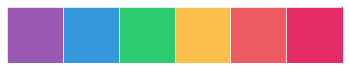

In [41]:
flatui = ["#9b59b6", "#3498db", "#2ecc71","#fcbf4a", "#ed5b61", "#e52c66"]
sns.palplot(sns.color_palette(flatui))

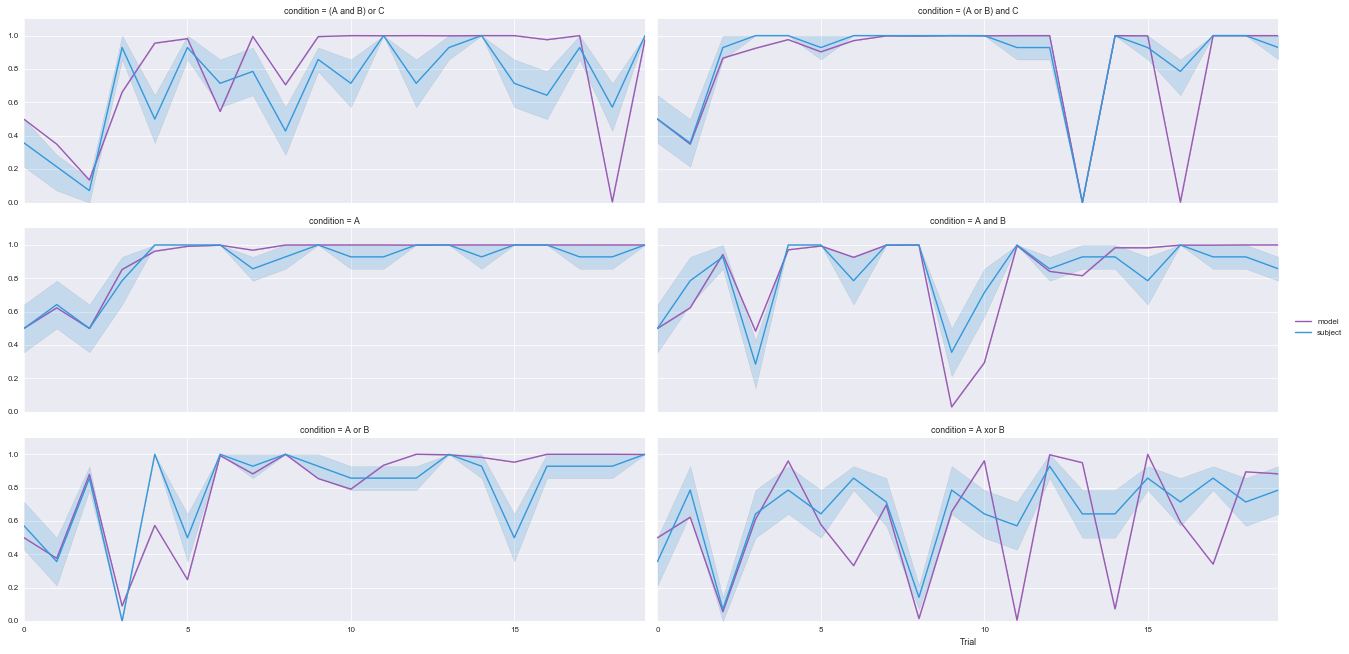

In [42]:
plt.figure(figsize=(6, 8))
g = sns.FacetGrid(df2, col='condition',col_wrap = 2, size = 3, aspect = 3)
g.map_dataframe(sns.tsplot, time="trial", unit="sub",
                value="hits", condition = 'type',color = sns.color_palette(flatui)).add_legend()
plt.xlabel('Trial')
g.set(ylim=(0, 1.1))
plt.savefig(home_dir + '/figures/revision/model_fits.svg',dpi=600)

In [46]:
#compute difference between ideal bayesian and subject model
fig_df = df2.groupby(['type','condition','sub']).mean()
for row in set(fig_df.index):
    x,cond,sub = row
    fig_df.loc[row,'diff'] = fig_df.loc[row,'accuracy'] - fig_df.loc[('model',cond,'model'),'accuracy']
fig_df = fig_df.loc['subject'].reset_index()

model_str = 'diff ~ 1 + C(condition,Sum)'
mixedfx = smf.mixedlm(model_str, fig_df, groups = fig_df['sub'])    
mixedfx = mixedfx.fit()
print mixedfx.summary()

                     Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         diff   
No. Observations:          84              Method:                     REML   
No. Groups:                14              Scale:                      0.0115 
Min. group size:           6               Likelihood:                 53.6191
Max. group size:           6               Converged:                  Yes    
Mean group size:           6.0                                                
------------------------------------------------------------------------------
                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                           -0.052    0.012 -4.468 0.000 -0.075 -0.029
C(condition, Sum)[S.(A and B) or C] -0.048    0.026 -1.817 0.069 -0.099  0.004
C(condition, Sum)[S.(A or B) and C]  0.063    0.026  2.407 0.016  0.012 

//anaconda/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


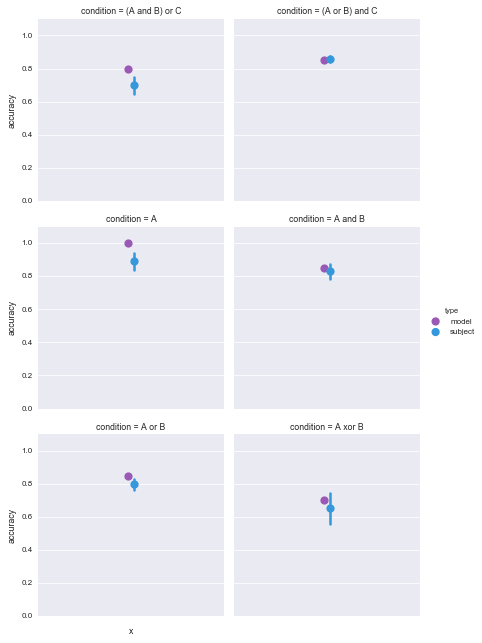

In [47]:
plt.figure(figsize=(6, 8))
fig_df = df2.groupby(['type','condition','sub']).mean().reset_index()

fig_df['x'] = ''
g = sns.factorplot(y="accuracy",hue = 'type',x = 'x',unit = 'sub',
               col = 'condition', data = fig_df,size = 3,
               join = False, col_wrap = 2,
                dodge = .03,
              palette = sns.color_palette(flatui))
g.set(ylim=(0, 1.1))
plt.ylabel('')
plt.xlabel('')
plt.savefig(home_dir + '/figures/revision/average_model_fits.svg',dpi=600)

In [7]:
#get accuracy
acc = df.groupby(['condition','sub']).mean()['hits'].reset_index()
model = afex.aov_ez('sub', 'hits', data = acc, within='condition')
print (model)
# acc_df
lsm  = importr('lsmeans')
pairwise = lsm.lsmeans(model, "condition", contr="pairwise", adjust="holm")
# print pairwise

Anova Table (Type 3 tests)

Response: hits
     Effect          df  MSE         F ges p.value
1 condition 2.97, 38.60 0.02 10.13 *** .40  <.0001

Sphericity correction method: GG 



In [8]:
#print accuracy of each model
acc_df = acc.set_index('condition')
for cond in set(acc_df.index):
    a = acc_df.loc[cond]['hits']
    t, p = scipy.stats.ttest_1samp(a,.5)
    print cond, np.mean(a), t, p*6

A 0.892857142857 14.7399183638 1.02760252291e-08
(A and B) or C 0.7 7.0856825043 4.93405113215e-05
A or B 0.796428571429 16.0190609958 3.67193884355e-09
A and B 0.828571428571 12.8728723824 5.37750166077e-08
(A or B) and C 0.860714285714 33.6666666667 2.96318012969e-13
A xor B 0.657142857143 3.25462633686 0.0376328108598


In [38]:
bayes = df2[df2['type'] == 'model']
bayes['accuracy'] = [int(round(x)) for x in bayes['hits']]
bayes = bayes.set_index('accuracy')
for cond in set(acc_df.index):
    ideal = bayes.loc[cond]['correct']
    subs = acc_df.loc[cond]['hits']

    diff = np.mean(ideal) - np.mean(subs)
    print cond, diff

A 0.107142857143
(A and B) or C 0.1
A or B 0.0535714285714
A and B 0.0214285714286
(A or B) and C -0.0107142857143
A xor B 0.0428571428571


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Anova Table (Type 3 tests)

Response: rt
     Effect          df     MSE      F ges p.value
1 condition 3.66, 47.52 6793.28 3.08 * .02     .03

Sphericity correction method: GG 



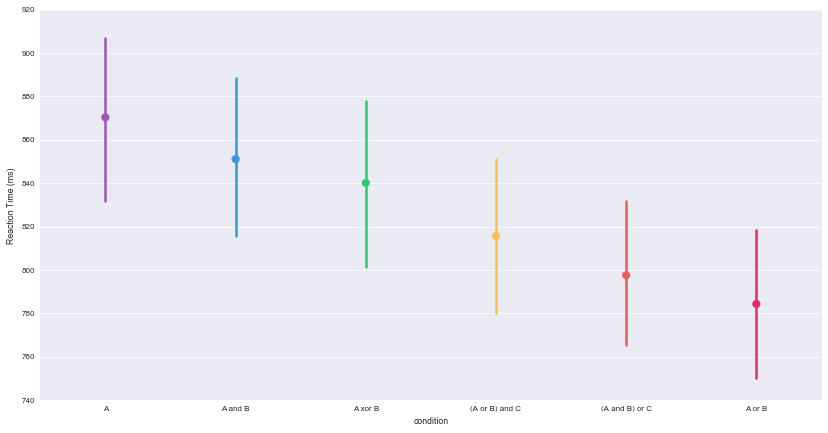

In [10]:
plt.figure(figsize=(14, 7))

sorted_conditions = df.groupby('condition').mean()['rt'].sort_values(ascending = False).index.values
g = sns.pointplot(y="rt",
                  unit = 'sub',
                  x = 'condition',
                  order = sorted_conditions,
                  data = df,
                  join = False,
                  palette = sns.color_palette(flatui))
sns.despine()
plt.ylabel('Reaction Time (ms)')
plt.savefig('../figures/revision/rt.svg',dpi=600)

no_nan_df = df[np.invert(np.isnan(df['rt']))]
model = afex.aov_ez('sub', 'rt', data = no_nan_df, within='condition')
print model

pairwise = lsm.lsmeans(model, "condition", contr="pairwise", adjust="holm")
# print pairwise

# RL functions

In [11]:
#take the feature values and return a state representation
def state_to_features(state, state_rep):
    if state_rep == 'naive': #one feature per state
        return [tuple(state)]
    
    if state_rep == 'feature': 
        features = []
        for n,s in enumerate(state):
            features.append(str(n) + '_'  + str(s))
        return features
    
    if state_rep == 'exhaustive': #all possible combinations of features
        features = [tuple(state)]
        for n1,s1 in enumerate(state):
            features.append(str(n1) + '_'  + str(s1))
            for n2,s2 in enumerate(state):
                if n1 < n2:
                    features.append( str(n1) + '_'  + str(s1) + '_' +  str(n2) + '_'  + str(s2) )
        return features

In [12]:
#get probability of each action under the softmax
def get_prob(Q,m): 
    probs = map(lambda q: np.exp(q * m), Q)
    probs = probs / np.sum(probs)
    return probs

In [13]:
#return rescorla-wagner update
def update_Q(rew,action,Q,alpha):
    PE = rew - Q[action]
    delta = alpha * (rew - Q[action])
    return delta

In [14]:
def get_LL(alpha, m, gamma, states, resp, outcomes, true, state_rep, return_LL):

    Q_values = {}
    associabilities = {}
    LL = 0
    deltas = []
    probs = []
    for n,a in enumerate(resp):
        #get q values for features
        features = state_to_features(states[:,n], state_rep)
        Q_state = np.array([0,0])
        for feat in features:
            if feat in Q_values.keys():
                Q = Q_values[feat]
            else: #initialize Q
                Q = np.array([0.0,0.0])
                Q_values[feat] = Q
                associabilities[feat] = [1.0]
            Q_state = Q_state + Q #sum up features

        #get choice probability
        p = get_prob(Q_state,m)[a]
        probs.append(p)
        if p < 1e-200 or np.isnan(p):
            update = np.log(1e-200)
        else:
            update = np.log(p)
        LL += update
        
        #update weights (with the state expectation used in PE)
        delta_Q = update_Q(outcomes[n],a,Q_state,alpha) #get updated Q
        deltas.append(delta_Q)
        for feat in features:
            Q = list(Q_values[feat])
            Q[a] = Q[a] + delta_Q * associabilities[feat][-1]
            Q[1-a] = Q[1-a] - delta_Q * associabilities[feat][-1]#learning is symmetric
            Q_values[feat] = np.array(Q) 
        
            #Update associabilities
            new_assoc = abs(delta_Q)*gamma + (1 - gamma)*associabilities[feat][-1]
            associabilities[feat].append(new_assoc)
    
    if return_LL:
        return LL
    else:
        return deltas, probs

In [15]:
#compute the likelihood for run. Useful for rule-by-rule comparisone
def get_cond_LL(params,sub_data,state_rep):
    alpha = params[0]
    m = params[1]
    gamma = params[2]

    cond_LL = {}
    for cond in cond_map2.values():
        c = sub_data[sub_data['condition'] == cond]
        states = np.array([c['a'].values,c['b'].values,c['c'].values])
        resp = c['resp'].values
        outcomes = c['hits'].values *2 -1
        true = c['true'].values *2 -1
        
        cond_LL[cond] = get_LL(alpha,m,gamma,states,resp,outcomes,true,state_rep,True)
 
    return cond_LL

In [25]:
#fit all subjects together with one M
def all_LL(params,state_rep,one_alpha,assoc):
    m = params[-1]

    LL = 0
    nsubs = len(sub_list)
    for n,sub in enumerate(sub_list):
        sub_data = df[df['sub'] == sub]
        
        #set parameters
        if one_alpha:
            alpha = params[0]
            if assoc:
                gamma = params[1]
        else:
            alpha = params[n]
            if assoc:
                gamma = params[nsubs + n]
            
        #loop through runs
        for cond in cond_map2.values():
            c = sub_data[sub_data['condition'] == cond]
            states = np.array([c['a'].values,c['b'].values,c['c'].values])
            resp = c['resp'].values
            outcomes = c['hits'].values *2 -1
            true = c['true'].values *2 -1
            
            if assoc:
                LL += get_LL(alpha,m,gamma,states,resp,outcomes,true,state_rep,True)
            else:
                LL += get_LL(alpha,m,0,states,resp,outcomes,true,state_rep,True)
    LL *= -1 #minimize
    return LL

# Run RL fitting

In [26]:
def run_group(state_rep,one_alpha,assoc):
    
    if one_alpha:#fit one m and one alpha
        if assoc:
            params = [.2,.2,3]
            bounds = ((0,1),(0,1),(.01,20))
        else:
            params = [.2,3]
            bounds = ((0,1),(.01,20))
    else:#fit one m and multiple alphas
        if assoc:
            params = [.2]*len(sub_list)*2 + [3] 
            bounds = tuple(map(tuple,[[0,1]]*len(sub_list)*2 + [[.01,20]]))
        else:
            params = [.2]*len(sub_list) + [3]
            bounds = tuple(map(tuple,[[0,1]]*len(sub_list) + [[.01,20]]))

    res = minimize(all_LL,params,args=(state_rep,one_alpha,assoc),
                   options={'disp': True},bounds = bounds)

    return res

In [8]:
def calc_bic(ll,n_params,n_obs):
    return -2*ll + n_params*np.log(n_obs)

In [9]:
def calc_aicc(ll,n_params,n_obs):
    return -2*ll + 2*n_params + (2*n_params * (n_params+1))/(n_obs*1.0 - n_params -1)

In [29]:
res_all = run_group('exhaustive',True,True)

In [30]:
res_all

      fun: 724.22262851127721
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00115961,  0.00092086, -0.0001819 ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 76
      nit: 14
   status: 0
  success: True
        x: array([ 0.14933693,  0.2374482 ,  1.3966806 ])

In [174]:
RL_results = {'ll':[],'model':[],'alpha':[],'m':[],'aic':[],
              'bic':[],'sub':[],'cond':[],'assoc':[],'gamma':[]}

ntrials_per_cond = 20
one_alpha = False
nsubs = len(sub_list)

for state_rep in ['feature','exhaustive']: #naive
    for assoc in [True]:
        res = run_group(state_rep,one_alpha,assoc)

        m = res.x[-1]
        for n,sub in enumerate(sub_list):
            sub_data = df[df['sub'] == sub]

            if one_alpha:
                alpha = res.x[0]
            else:
                alpha = res.x[n]
                if assoc:
                    gamma = res.x[nsubs + n]
                    n_params = 3
                else:
                    gamma = 0
                    n_params = 2
                    
            params = [alpha, m, gamma]
            cond_LL = get_cond_LL(params,sub_data,state_rep)

            for cond in cond_map2.values():
                bic = calc_bic(cond_LL[cond],n_params,ntrials_per_cond)
                aic = calc_aicc(cond_LL[cond],n_params,ntrials_per_cond)

                RL_results['ll'].append(cond_LL[cond])
                RL_results['cond'].append(cond)
                RL_results['sub'].append(str(sub))
                RL_results['model'].append(state_rep)
                RL_results['alpha'].append(alpha)
                RL_results['m'].append(m)
                RL_results['aic'].append(aic)
                RL_results['bic'].append(bic)
                RL_results['assoc'].append(assoc)
                RL_results['gamma'].append(gamma)
results = pd.DataFrame(RL_results)

In [205]:
results.to_csv(op.abspath('../results.csv'),index = False)

In [293]:
results.groupby(['model','assoc']).mean()

aic     alpha  assoc_init        bic     gamma  \
model      assoc                                                         
exhaustive False  21.657471  0.115429           1  22.943053  0.000000   
           True   23.959176  0.143872         NaN  25.446373  0.282755   
feature    False  25.675265  0.150390           1  26.960847  0.000000   
           True   27.813943  0.221539         NaN  29.301140  0.194434   
naive      False  22.993883  0.454942           1  24.279465  0.000000   
           True   25.643068  0.056466         NaN  27.130265  0.479579   

                         ll          m  
model      assoc                        
exhaustive False  -8.475794   1.633030  
           True   -8.229588   1.636514  
feature    False -10.484691   1.486582  
           True  -10.156972   1.469652  
naive      False  -9.144000   2.383901  
           True   -9.071534  20.000000

(array([ 5.,  1.,  1.,  2.,  3.,  1.,  0.,  0.,  0.,  1.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

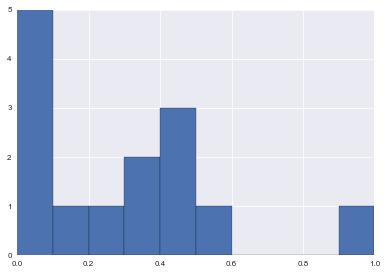

In [330]:
plt.hist(results.set_index(['model','assoc','cond']).loc[('exhaustive',True,"A"),'gamma'])

# Compute the likelihood under the Bayesian Rational Rules Model

In [15]:
ll_df.mean()

aic    inf
bic    inf
ll    -inf
dtype: float64

In [14]:
model = df2[df2['type'] == 'model']
alpha = 1
ll_df = {'sub':[],'cond':[],'ll':[],'aic':[],'bic':[],'model':[]}

for sub in sub_list:
    sub_df = df[df['sub'] == sub]

    for cond in cond_map2.values():
        cond_df = sub_df[sub_df['condition'] == cond]
        model_cond = model[model['condition'] == cond]
        model_prob = model_cond['hits'].values
        hits = cond_df['hits']
        
        ll = 0
        for n,x in enumerate(hits):
            m_prob = (1-alpha)*.5 + model_prob[n]*alpha
            log_prob = np.log(scipy.stats.bernoulli.pmf(x,m_prob))
            ll += log_prob
        ll_df['sub'].append(sub)
        ll_df['cond'].append(cond)
        ll_df['ll'].append(ll)
        ll_df['aic'].append(calc_aicc(ll,1,20))
        ll_df['bic'].append(calc_bic(ll,1,20))
        ll_df['model'].append('bayes')
        
ll_df = pd.DataFrame(ll_df)
ll_df['assoc'] = ''

In [248]:
RL_results = pd.concat([ll_df,results])

# Do RFX bayesian model comparison

In [264]:
assoc_map = {True:'PH',False:'std','':''}
RL_results['model_id'] = [x + '_' + assoc_map[y] for x,y in zip(RL_results['model'],
                                                                     RL_results['assoc'])]
RL_results = RL_results.sort_values(by = ['model_id','cond','sub'])

In [296]:
#write to text file
path = '/Users/ianballard/Dropbox/rule_learning/behav_data/modeling/'
for m in set(RL_results['model_id'].values):

    if m == 'bayes_':
        n_params = 1
    elif m in ['exhaustive_std','feature_std','naive_std']:
        n_params = 2
    else:
        n_params = 3
        
    total_ll = RL_results[RL_results['model_id'] == m].groupby('sub').sum()['ll'].values
    aic = map(lambda x: calc_aicc(x,n_params,120),total_ll)
    bic = map(lambda x: calc_bic(x,n_params,120),total_ll)

    np.savetxt(path + m + '_aic',aic)
    np.savetxt(path + m + '_bic',bic)

In [266]:
%load_ext pymatbridge

Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-5a499b82-6a65-44be-a376-21606595e1aa
Send 'exit' command to kill the server
.........................MATLAB started and connected!


//anaconda/lib/python2.7/site-packages/IPython/nbformat.py:13: ShimWarning: The `IPython.nbformat` package has been deprecated. You should import from nbformat instead.
  "You should import from nbformat instead.", ShimWarning)


In [321]:
%%matlab -o pxp_b
path = '/Users/ianballard/Dropbox/rule_learning/behav_data/modeling/';
ic = '_bic';
naive_std = textread([path,'naive_std',ic]);
feature_std = textread([path,'feature_std',ic]);
exhaustive_std = textread([path,'exhaustive_std',ic]);
bayes = textread([path,'bayes_',ic]);
naive_PH = textread([path,'naive_PH',ic]);
feature_PH = textread([path,'feature_PH',ic]);
exhaustive_PH = textread([path,'exhaustive_PH',ic]);
%%lc = [bayes,exhaustive_std, naive_std, feature_std,exhaustive_PH, naive_PH, feature_PH];
lc = [bayes, exhaustive_PH, naive_PH, feature_PH];
lc = lc*-1/2; %%https://www.jiscmail.ac.uk/cgi-bin/webadmin?A2=spm;89534562.1511
[alpha, exp_r, xp, pxp_b, bor] = spm_BMS(lc);

In [322]:
%%matlab -o pxp_a
ic = '_aic';
naive_std = textread([path,'naive_std',ic]);
feature_std = textread([path,'feature_std',ic]);
exhaustive_std = textread([path,'exhaustive_std',ic]);
bayes = textread([path,'bayes_',ic]);
naive_PH = textread([path,'naive_PH',ic]);
feature_PH = textread([path,'feature_PH',ic]);
exhaustive_PH = textread([path,'exhaustive_PH',ic]);
%%lc = [bayes,exhaustive_std, naive_std, feature_std,exhaustive_PH, naive_PH, feature_PH];
lc = [bayes, exhaustive_PH, naive_PH, feature_PH];
%%lc = [bayes,naive,feature];
lc = lc*-1/2; %%https://www.jiscmail.ac.uk/cgi-bin/webadmin?A2=spm;89534562.1511
[alpha,exp_r,xp,pxp_a,bor] = spm_BMS(lc);

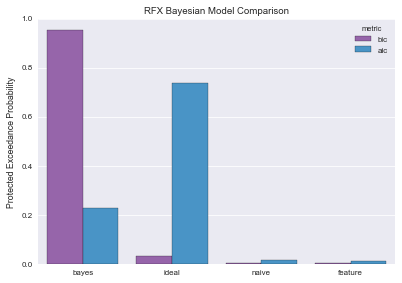

In [323]:
model = ['bayes','ideal','naive','feature']
# model = ['bayes','naive','feature']

xp_df = pd.DataFrame({'model':model*2,
                      'Protected Exceedance Probability':list(pxp_b[0]) + list(pxp_a[0]),
                     'metric':['bic']*len(model) + ['aic']*len(model) })
ax = sns.barplot(x = 'model', y = 'Protected Exceedance Probability',
            hue = 'metric',data = xp_df,palette = sns.color_palette(flatui))
plt.title('RFX Bayesian Model Comparison')
plt.ylabel('Protected Exceedance Probability')
plt.xlabel('')
ax.set_ylim([0,1])
plt.savefig('../figures/PH/model_fit_PH.png',dpi=600)

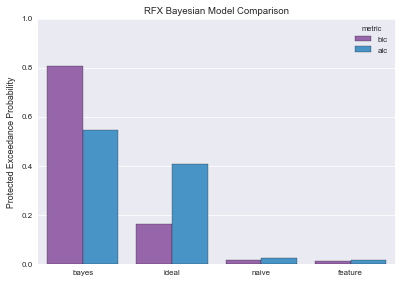

In [10]:
model = ['bayes','ideal','naive','feature']
# model = ['bayes','naive','feature']

xp_df = pd.DataFrame({'model':model*2,
                      'Protected Exceedance Probability':list(pxp_b[0]) + list(pxp_a[0]),
                     'metric':['bic']*len(model) + ['aic']*len(model) })
ax = sns.barplot(x = 'model', y = 'Protected Exceedance Probability',
            hue = 'metric',data = xp_df,palette = sns.color_palette(flatui))
plt.title('RFX Bayesian Model Comparison')
plt.ylabel('Protected Exceedance Probability')
plt.xlabel('')
ax.set_ylim([0,1])
plt.savefig('../figures/model_fit_full.png',dpi=600)

# Now do model comparison within each condition

In [144]:
#write to text file
path = '/Users/ianballard/Dropbox/rule_learning/behav_data/modeling/'
for m in set(RL_results['model'].values):

    if m == 'bayes':
        n_params = 1
    else:
        n_params = 2

    for cond in cond_map2.values():
        cond_res = RL_results[RL_results['cond'] == cond]
        total_ll = cond_res[cond_res['model'] == m]['ll'].values
        aic = map(lambda x: calc_aicc(x,n_params,20),total_ll)
        bic = map(lambda x: calc_bic(x,n_params,20),total_ll)

        np.savetxt(path + m + '_' + cond + '_aic',aic)
        np.savetxt(path + m + '_' + cond + '_bic',bic)

In [48]:
%%matlab -o pxp_b
path = '/Users/ianballard/Dropbox/rule_learning/behav_data/modeling/';
ic = '_aic';
pxp_b = [];
c = {'A and B', 'A or B', '(A and B) or C', 'A xor B', 'A', '(A or B) and C'};

for i=1:6
    naive = textread([path,'naive','_',c{i},ic]);
    feature = textread([path,'feature','_',c{i},ic]);
    exhaustive = textread([path,'exhaustive','_',c{i},ic]);
    bayes = textread([path,'bayes','_',c{i},ic]);
    lc = [bayes,exhaustive,naive,feature];
    lc = lc*-1;
    [alpha,exp_r,xp,pxp,bor] = spm_BMS(lc);
    pxp_b = [pxp_b;pxp];
end

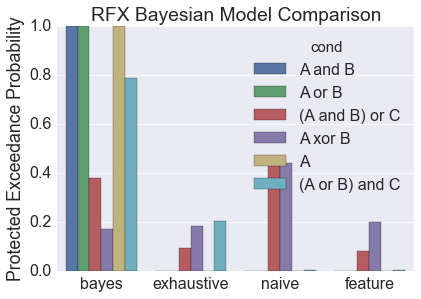

In [49]:
xp_cond_df = {'model':[],'cond':[],'Protected Exceedance Probability':[]}
model = ['bayes','exhaustive','naive','feature']

for n,row in enumerate(pxp_b):
    xp_cond_df['model'].extend(model)
    xp_cond_df['Protected Exceedance Probability'].extend(row)
    xp_cond_df['cond'].extend([cond_map2.values()[n]]*len(model))

xp_cond_df = pd.DataFrame(xp_cond_df)
sns.barplot(x = 'model', y = 'Protected Exceedance Probability',hue = 'cond',data = xp_cond_df)
plt.title('RFX Bayesian Model Comparison')
plt.ylabel('Protected Exceedance Probability')
plt.xlabel('')
plt.savefig('../figures/model_fit_by_cond.jpg')

# Plot surprise and KL divergence

(0.27374992068322362, 0.0032071610397750713)


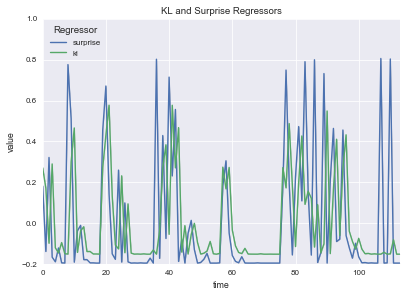

In [23]:
#load data
data = scipy.io.loadmat('model_accuracy.mat')
correct_answers = data['model_accuracy']
correct_answers = correct_answers[1:,:].ravel(order = 'F') #drop first entry because its NaN for KL
surprise = 1 - correct_answers
kl = data['kl_div']
kl = kl[1:,:].ravel(order = 'F')

#subtract means
surprise = surprise - np.mean(surprise)
kl = kl - np.nanmean(kl)

#plot
df_kl = {'Regressor':['surprise']*len(surprise) + ['kl']*len(kl), 'time':range(len(kl)) + range(len(kl)),
     'value': list(surprise) + list(kl), 'sub' : np.ones(2*len(kl))}
df_kl = pd.DataFrame(df_kl)
sns.tsplot(value = 'value', condition = 'Regressor', time = 'time', unit = 'sub',data = df_kl)
plt.savefig('../figures/kl_surprise')
plt.title('KL and Surprise Regressors')
print scipy.stats.pearsonr(surprise,kl)

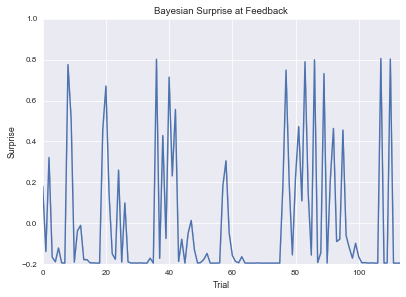

In [29]:
sns.tsplot(surprise)
plt.ylabel('Surprise')
plt.xlabel('Trial')
plt.title('Bayesian Surprise at Feedback')
plt.savefig(home_dir + '/figures/surprise.png',dpi = 600)

# Compute and plot the rule complexity

In [15]:
def count_and_or(in_str):
    count = 1
    count += in_str.count('and')
    count += in_str.count('or')
    return count

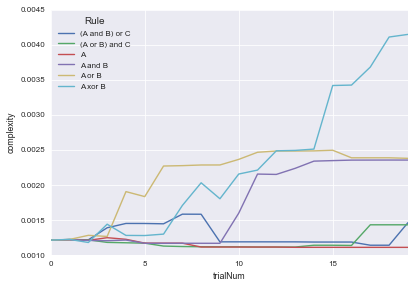

In [16]:
rule_map = {'AandB.txt':'A and B','AandB_orC.txt': '(A and B) or C','AxorB.txt':'A xor B',
           'A.txt':'A','AorB_andC.txt':'(A or B) and C', 'AorB.txt':'A or B'}
data = pd.read_csv('fit_renormalized.txt',delimiter = ' ')
data['Rule'] = [rule_map[x] for x in data['Rule'].values]
data = data.sort(['Rule'])
counts = map(count_and_or,data['hypothesis'].values)

data['complexity'] = np.array(counts * data['probrenormalized'].values).astype(float)
sns.tsplot(value='complexity',
           condition='Rule',
           time='trialNum',
           unit='hypNum', 
           data=data,
          err_style = None)
plt.savefig('../figures/complexity')

# Compute and plot the model entropy

In [123]:
def multinomial_entropy(d):
    entropy = 0
    for key in d.keys():
        entropy -= d[key] * math.log(d[key],2) #compute entropy in shannons
    return entropy

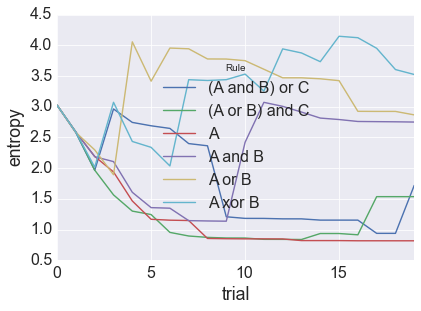

In [143]:
rules = list(set(data['Rule'].values))
entropies = []
for rule in rules:
    rule_df = data[data['Rule'] == rule]
    for trial in range(0,20):
        trial_df = rule_df[rule_df['trialNum'] == trial]
        probs = trial_df['probrenormalized'].values
        entropy = map(lambda x: x*np.log(x),probs) #compute entropy
        entropy = sum(entropy)*-1
        entropies.append(entropy)

condition = np.array(rules).repeat(20)
trial = range(20)*6
sub =[1]*(len(trial)) 

entropy_df = {'entropy':entropies, 'Rule': condition, 'trial': trial, 'sub':sub}
entropy_df = pd.DataFrame(entropy_df).sort(['Rule'])
sns.tsplot(value='entropy',
           condition='Rule',
           time='trial',
           unit='sub', 
           data=entropy_df)
plt.savefig('../figures/entropy')

# Simulate RL for best parameters of exhaustive model

In [68]:
# pe, probs = get_LL(.2,1.4,0,states,resp,outcomes,true,'exhaustive',False)
# pe

In [69]:
# alpha, gamma, m = [ 0.12774507,  0 ,  1.63 ]
# alpha, gamma, m = [ 0.14933693,  0.2374482 ,  1.3966806 ]
print alpha, gamma, m
state_rep = 'exhaustive'
assoc = True
return_LL = False
cond_list_ordered = ['A and B','(A and B) or C','A or B','A','A xor B','(A or B) and C']
out_map = {1:'Correct',-1:'Incorrect'}
outcomes_ordered = []
deltas = []
rl_predictions = {'condition':[],'hits':[],'trial':[],'pe':[]}
for sub in sub_list:
    sub_df = df[df['sub'] == sub]
    
    d = []
    for n,cond in enumerate(cond_list_ordered):
        c = sub_df[sub_df['condition'] == cond]
        states = np.array([c['a'].values,c['b'].values,c['c'].values])

        resp = c['resp'].values
        outcomes = c['hits'].values *2 -1
        true = c['true'].values *2 -1
        outcomes_ordered.extend(outcomes)
        
        pe, probs = get_LL(alpha,m,gamma,states,resp,outcomes,true,state_rep,return_LL)
        d.append(pe)
        
        #update RL prediction df
        rl_predictions['condition'].extend([cond]*len(probs))
        rl_predictions['hits'].extend(probs)
        rl_predictions['pe'].extend(pe)
        rl_predictions['trial'].extend(range(len(probs)))
    d = np.array(d)
    deltas.extend(d.ravel(order = 'C'))
    f = os.path.abspath('/Users/ianballard/Dropbox/rule_learning/mri_data/rule_learning_' + sub + '/rl_pe_PH')
    np.savetxt(f,d.T)
    
outcomes_labels = [out_map[x] for x in outcomes_ordered]
rl_predictions = pd.DataFrame(rl_predictions)
rl_predictions = rl_predictions.groupby(['condition','trial']).mean().reset_index() #all subjects have same estimate
rl_predictions['sub'] = 'RL'
rl_predictions['type'] = 'RL'
rl_predictions.to_csv(op.abspath('../rl_predictions_PH.csv'),index = False)

0.14933693 0.2374482 1.3966806


# Examine PE and Surprise signals grouped by outcome valence

In [50]:
rl = pd.read_csv('../rl_predictions.csv')
ph = pd.read_csv('../rl_predictions_PH.csv')
scipy.stats.pearsonr(rl['pe'],ph['pe'])
print len(rl)

120


Ttest_indResult(statistic=47.222164411462202, pvalue=2.3332274548732144e-310)
r 0.755391936757 r squared 0.570616978118 t 2.33322745487e-310


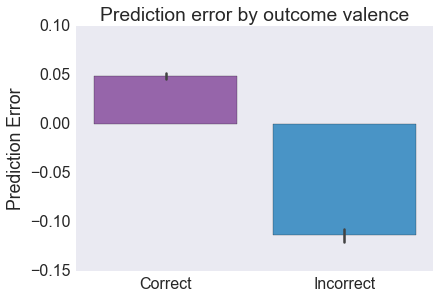

In [107]:
deltas = np.array(deltas)
pes = {'Reward Prediction Error': deltas,'outcome valence': outcomes_ordered, 'Outcome':outcomes_labels}
pes = pd.DataFrame(pes)

print scipy.stats.ttest_ind(pes[pes['outcome valence'] == 1]['Reward Prediction Error'].values,
                     pes[pes['outcome valence'] == -1]['Reward Prediction Error'].values)
r,t = scipy.stats.pearsonr(pes['Reward Prediction Error'].values,
                     pes['outcome valence'].values)
print 'r',r, 'r squared',r**2, 't',t
sns.barplot(y='Reward Prediction Error',x='Outcome', data=pes,palette = sns.color_palette(flatui))
plt.title('Prediction error by outcome valence')
plt.ylabel('Prediction Error')
plt.xlabel('')
plt.savefig('../figures/rpe_outcome',dpi = 600,bbox_inches='tight')

Ttest_indResult(statistic=-21.825634578567499, pvalue=3.6556622548225421e-93)
r -0.470227376505 r squared 0.221113785614 t 3.65566225482e-93


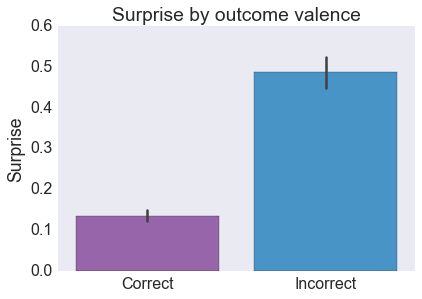

In [108]:
correct_answers = scipy.io.loadmat('model_accuracy.mat')
correct_answers = correct_answers['model_accuracy'].ravel(order = 'F')
correct_answers = 1-correct_answers

pes = {'Surprise': list(correct_answers)*len(sub_list),'outcome valence': outcomes_ordered,'Outcome':outcomes_labels}
pes = pd.DataFrame(pes)

print scipy.stats.ttest_ind(pes[pes['outcome valence'] == 1]['Surprise'].values,
                     pes[pes['outcome valence'] == -1]['Surprise'].values)
r,t = scipy.stats.pearsonr(pes['Surprise'].values,
                     pes['outcome valence'].values)
print 'r',r, 'r squared',r**2, 't',t
sns.barplot(y='Surprise',x='Outcome', data=pes,palette = sns.color_palette(flatui))
plt.title('Surprise by outcome valence')
plt.ylabel('Surprise')
plt.xlabel('')
plt.savefig('../figures/surprise_outcome', dpi = 600,bbox_inches='tight')

(-5.4794638018423507, 4.9508392829225921e-08)
r -0.135969584605 r squared 0.0184877279377 t 4.95083928292e-08


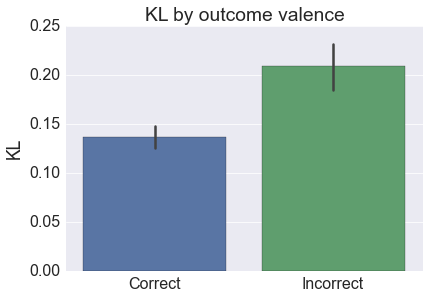

In [119]:
correct_answers = scipy.io.loadmat('model_accuracy.mat')
correct_answers = correct_answers['kl_div'].ravel(order = 'F')

pes = {'Surprise': list(correct_answers)*len(sub_list),'outcome valence': outcomes_ordered,'Outcome':outcomes_labels}
pes = pd.DataFrame(pes)
pes = pes.dropna()

print scipy.stats.ttest_ind(pes[pes['outcome valence'] == 1]['Surprise'].values,
                     pes[pes['outcome valence'] == -1]['Surprise'].values)
r,t = scipy.stats.pearsonr(pes['Surprise'].values,
                     pes['outcome valence'].values)
print 'r',r, 'r squared',r**2, 't',t
sns.barplot(y='Surprise',x='Outcome', data=pes)
plt.title('KL by outcome valence')
plt.ylabel('KL')
plt.xlabel('')
plt.savefig('../figures/KL_outcome', dpi = 600)

(-5.3392066009979402, 1.0610499280709812e-07)
r -0.129247655237 r squared 0.0167049563843 t 1.06104992807e-07


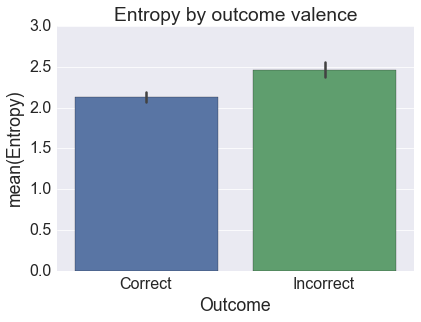

In [133]:
entropy_ordered = []
for c in cond_list_ordered:
    c_df = entropy_df[entropy_df['Rule'] == c]
    e = c_df.sort(['trial'])['entropy'].values
    entropy_ordered.extend(e)

    pes = {'Entropy': list(entropy_ordered)*len(sub_list),'outcome valence': outcomes_ordered,'Outcome':outcomes_labels}
pes = pd.DataFrame(pes)
pes = pes.dropna()

print scipy.stats.ttest_ind(pes[pes['outcome valence'] == 1]['Entropy'].values,
                     pes[pes['outcome valence'] == -1]['Entropy'].values)
r,t = scipy.stats.pearsonr(pes['Entropy'].values,
                     pes['outcome valence'].values)
print 'r',r, 'r squared',r**2, 't',t
sns.barplot(y='Entropy',x='Outcome', data=pes)

plt.title('Entropy by outcome valence')

In [146]:
entropy_diff = []
for c in cond_list_ordered:
    c_df = entropy_df[entropy_df['Rule'] == c]
    e = c_df.sort(['trial'])['entropy'].values

    e_diff = [np.NaN] #no diff for first trial
    for i in range(1,len(e)):
        diff = e[i] - e[i-1]
        e_diff.append(diff)
    entropy_diff.append(e_diff)

entropy_diff = np.array(entropy_diff).T
np.savetxt('entropy_diff.txt',entropy_diff)
entropy_diff = np.array(entropy_diff).ravel(order = 'F')

correct_answers = scipy.io.loadmat('model_accuracy.mat')
kl = correct_answers['kl_div'].ravel(order = 'F')
surprise = correct_answers['model_accuracy'].ravel(order = 'F')
surprise = 1 - surprise

surprise = [x for i,x in enumerate(surprise) if not np.isnan(kl[i])]
entropy_diff = [x for x in entropy_diff if not np.isnan(x)]
kl = [x for x in kl if not np.isnan(x)]
r,t = scipy.stats.pearsonr(kl, entropy_diff)
print r,t
r,t = scipy.stats.pearsonr(surprise, entropy_diff)
print r,t

0.208232813293 0.0261991992918
-0.0520403442473 0.582396085505


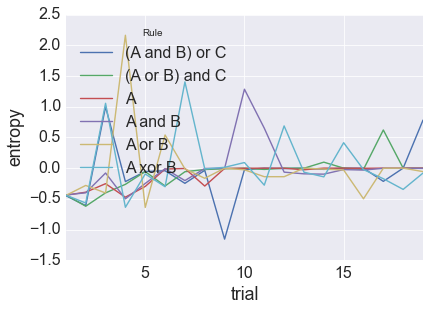

In [137]:
condition = np.array(cond_list_ordered).repeat(19)
trial = range(1,20)*6
sub =[1]*(len(trial)) 

entropy_df = {'entropy':entropy_diff, 'Rule': condition, 'trial': trial, 'sub':sub}
entropy_df = pd.DataFrame(entropy_df).sort(['Rule'])
sns.tsplot(value='entropy',
           condition='Rule',
           time='trial',
           unit='sub', 
           data=entropy_df)
plt.savefig('../figures/entropy_diff')

# Plot model fits

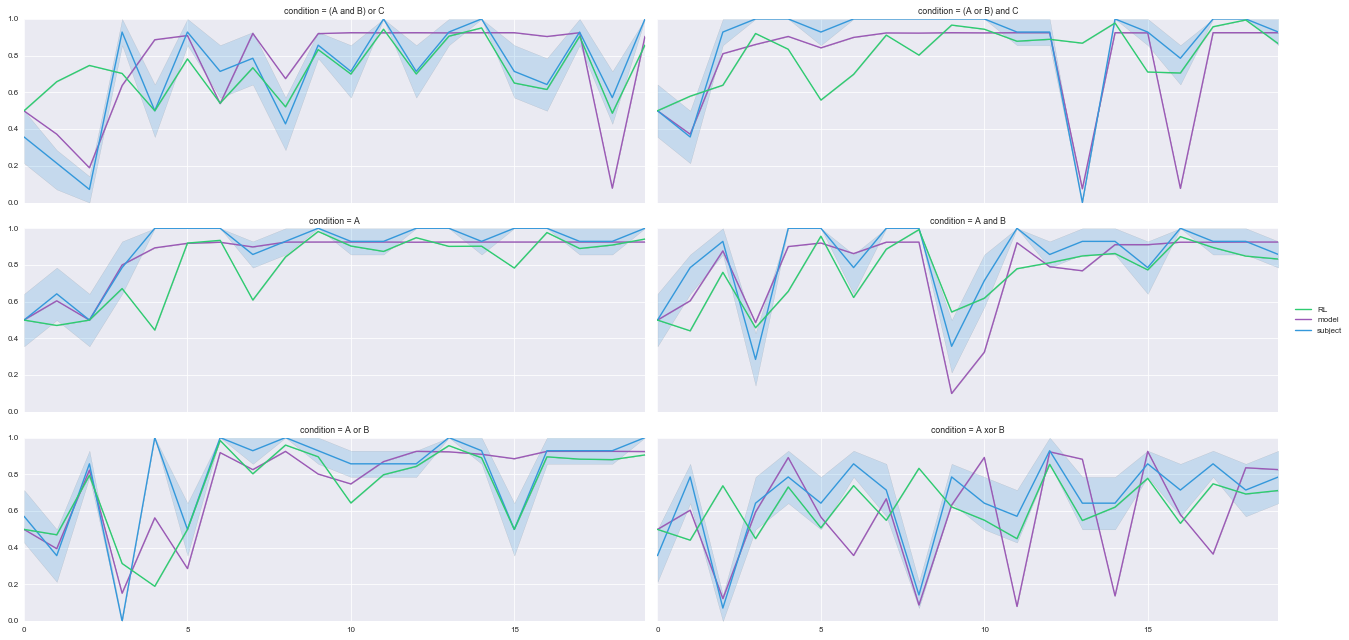

In [468]:
df_noised = df2.copy().set_index('type').sort_index()

#first smooth out Bayesian model prediction with noise
alpha = .85
probs = df_noised.loc['model','hits'].values
probs = [(1-alpha)*.5 + x*alpha for x in probs]

df_noised.loc['model','hits'] = probs
df_noised.loc['model','hits'].head()
df_noised = df_noised.reset_index()
df_noised = df_noised.sort_values(by = ['type','condition','sub','trial'])

#add RL estimate
df_noised = pd.concat([df_noised,rl_predictions])

plt.figure(figsize=(8, 20))
g = sns.FacetGrid(df_noised, col='condition',col_wrap = 2, aspect = 3)
g.map_dataframe(sns.tsplot, time="trial", unit="sub",
                value="hits", condition = 'type',color = sns.color_palette(flatui)).add_legend()
plt.savefig(home_dir + '/figures/model_fits_noise.png',dpi=600)